# Report

---

In this notebook, we will see an implementation for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

## Implementation specs

### Summary

We implement a [Deep Q-Network](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) with the following extensions:

* [Double learning](https://arxiv.org/abs/1509.06461)
* [Dueling networks](https://arxiv.org/abs/1511.06581)
* [Prioritized Experience Replay](https://arxiv.org/abs/1511.05952)

A summary of famous extensions to the DQN framework can be found on the [Rainbow DQN paper](https://arxiv.org/abs/1710.02298) -- though we only implement the extensions listed above.

Note that this implementation is built as an extension of the provided solution for the [DQN example](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn/solution), rather than implemented from scratch, but adds non-trivial technical extensions to it.


### Details

The agent keeps track of two DQNs: a local version, and a target version, one updated less often than the other.

#### Dueling DQNs

Each DQN is an Actor (Policy) model, mapping states to a list of action values for each action:

    s -> [Q(s, a) for a in Actions]

The network structure of the dueling networks generate independent estimates for the value function and the advantage function:

    s -> Linear(state_size, fc1_units) -> ReLU -> x
    x -> Linear(fc1_units, fc2_units / 2) -> ReLU -> Linear(fc2_units / 2, 1) -> V(s)
    x -> Linear(fc1_units, fc2_units / 2) -> ReLU -> Linear(fc2_units / 2, action_size) -> A(s, a)

The estimates for value and advantage are then combined as follows:

$$ Q(s, a) = V(s) + \left(A(s, a) - \frac{1}{|\mathcal{A}|} \sum_{a_i \in \mathcal{A}} A(s, a_i) \right)$$
     
By default, 64 units are used on the first layer, and 64 units on the second layer, split between the value function network and the advantage function network.

These networks are defined in `model.py`.

#### Double DQNs

On the update operation, rather than just using the local network to both select the best action and compute its estimated
value, we use the local network to pick an action, and then use the target network to compute its estimated value:

$$ Q_{expected} = R + \gamma Q_{network}(s', \underset{a \in \mathcal{A}}{\operatorname{argmax}} Q_{local}(s', a)) $$

This operation is performed at the `learn` method on the agent, in `dqn_agent.py`.
    
    
#### Prioritized Experience Replay
    
Rather than just keeping a buffer of experiences (s, a, r, s', d), each experience i has a weight $\delta_i$ associated with it, based on the error between the estimated Q value and the current Q value for that experience when last evaluated:

$$ \delta_i = Q_{target} - Q_{expected}$$

$$ p_i = | \delta_i | + \epsilon $$

$$ P_i = \frac{p_i^{\alpha}}{\sum_j p_j^{\alpha}} $$

$$ w_i = \left(\frac{1}{N} \frac{1}{P_i}\right)^{\beta} $$

The experiences are then drawn with probabilities proportional to $w_i p_i$.  

Unlike on the PER paper, we do not do annealing on $\beta$, instead picking a fixed value.

As indicated on the PER paper, we use a binary tree as a helper data structure to quickly draw samples from a non-uniform distribution; implementation details are available in `sum_tree.py`.

The replay buffer is implemented in `memory.py`.


#### Hyperparameters

Agent hyperparameters may be passed as constructor arguments to `Agent`.  The default values, used in this workbook, are:

| parameter    | value  | description                                                                   |
|--------------|--------|-------------------------------------------------------------------------------|
| buffer_size  | 100000 | Number of experiences to keep on the replay memory for the DQN                |
| batch_size   | 64     | Minibatch size used at each learning step                                     |
| gamma        | 0.99   | Discount applied to future rewards                                            |
| tau          | 1e-3   | Scaling parameter applied to soft update                                      |
| learn_rate   | 5e-4   | Learning rate used for the Adam optimizer                                     |
| update_every | 4      | Number of agent steps between update operations                               |
| per_epsilon  | 1e-5   | Constant added to each probability weight for Prioritized Experience Replay   |
| per_alpha    | 0.6    | PER hyperparameter, exponent to scale probability weights                     |
| per_beta     | 0.9    | PER hyperparameter, exponent to reduce annealing bias                         |

Training hyperparameters are passed on the training function itself, `dqn`, defined below.  The default values are:

| parameter                     | value            | description                                                             |
|-------------------------------|------------------|-------------------------------------------------------------------------|
| n_episodes                    | 2000             | Maximum number of training episodes                                     |
| max_t                         | 1000             | Maximum number of steps per episode                                     |
| eps_start, eps_end, eps_decay | (1, 0.01, 0.995) |  Interpolation parameters for decaying epsilon on epsilon-greedy policy |
| solved_score                  | 13 (later 16)    | Average score required to consider problem solved                       |

## Execution

Import required system packages:

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [3]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Let's get the state and action dimensions, and initialize our agent:

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

In [5]:
# state size
state_size = len(env_info.vector_observations[0])
print('State size: ', state_size)

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

State size:  37
Number of actions: 4


In [6]:
# Initialize agent

from dqn_agent import Agent

agent = Agent(
    state_size=state_size, 
    action_size=action_size,
    seed=0
)

Now, let's define the interaction with the agent:

In [7]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, solved_score=13):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= solved_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

Episode 100	Average Score: 0.80
Episode 200	Average Score: 4.60
Episode 300	Average Score: 7.56
Episode 400	Average Score: 10.85
Episode 463	Average Score: 13.01
Environment solved in 363 episodes!	Average Score: 13.01


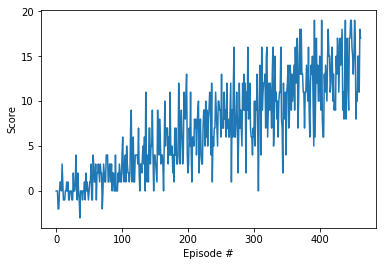

In [8]:
scores = dqn(solved_score=13)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

We are going to go above and beyond and retrain the agent to a higher score, however:

Episode 100	Average Score: 1.05
Episode 200	Average Score: 3.57
Episode 300	Average Score: 6.94
Episode 400	Average Score: 9.940
Episode 500	Average Score: 13.57
Episode 600	Average Score: 14.63
Episode 700	Average Score: 14.96
Episode 800	Average Score: 15.38
Episode 825	Average Score: 16.04
Environment solved in 725 episodes!	Average Score: 16.04


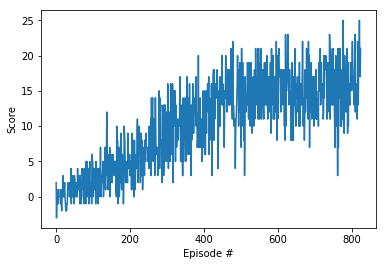

In [14]:
agent = Agent(
    state_size=state_size, 
    action_size=action_size,
    seed=0
)
scores = dqn(solved_score=16)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Finally, we can watch the solved agent:

In [21]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 18.0


When done, close the environment:

In [22]:
env.close()

## Ideas for future work

* Implement remaining extensions on Rainbow DQN for this toy example
* Perform a larger hyperparameter search, including hyper parameter annealing
* Review literature for more recent DQN extensions